# DCGAN with Labeled Faces in the Wild Dataset

- torch-ganの`create_datasets.py`で`lfw.hdf5`を作成
- http://vis-www.cs.umass.edu/lfw/
- http://torch.ch/blog/2015/11/13/gan.html
- https://github.com/skaae/torch-gan

In [8]:
%matplotlib inline
import matplotlib as mpl
mpl.use('Agg')

import os
import h5py
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Reshape, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

np.random.seed(7)

/Users/koichiro.mori/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## データセットをロード

In [14]:
f = h5py.File('./data/lfw.hdf5', 'r')
print(list(f.keys()))
lfw = f['lfw'][:]
# [-1, 1]に正規化
lfw = (lfw - 0.5) / 0.5
print(np.max(lfw), np.min(lfw))
print(lfw.shape)
X_train = lfw.transpose((0, 2, 3, 1))
print(X_train.shape)

['lfw']
1.0 -1.0
(13233, 3, 64, 64)
(13233, 64, 64, 3)


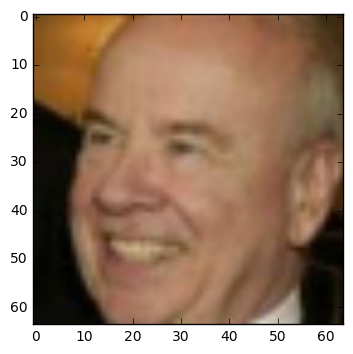

In [16]:
plt.imshow((X_train[1] / 2) + 0.5)

## DCGANモデルを作成

In [10]:
def generator_model():
    model = Sequential()
    model.add(Dense(4 * 4 * 1024, input_dim=100))
    model.add(Reshape((4, 4, 1024), input_shape=(4 * 4 * 1024, )))
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(512, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(256, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(128, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(3, (3, 3), padding='same'))
    model.add(Activation('tanh'))
    return model

def discriminator_model():
    model = Sequential()
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=(64, 64, 3)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.2))
    model.add(Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.2))
    model.add(Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(1024, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

model = discriminator_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 128)       9728      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 8, 8, 512)         3277312   
__________

In [21]:
def plot_images(images, fname=None, figsize=(12, 12), rows=4):
    assert images.shape[0] == 16
    # imagesは[-1, 1]なので描画できるように[0, 1]に戻す
    images = (images / 2) + 0.5
    f = plt.figure(figsize=figsize)
    for i in range(len(images)):
        sp = f.add_subplot(rows, len(images) // rows, i + 1)
        sp.axis('off')
        plt.imshow(images[i])
    if fname is not None:
        plt.savefig(fname)

In [22]:
BATCH_SIZE = 64
NUM_EPOCH = 100
GENERATED_IMAGE_PATH = 'generated_images_lfw/'
MODEL_PATH = 'models_lfw/'

if not os.path.exists(GENERATED_IMAGE_PATH):
    os.mkdir(GENERATED_IMAGE_PATH)

if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

# discriminatorのみのモデル構築
discriminator = discriminator_model()
d_opt = Adam(lr=1e-5, beta_1=0.1)
discriminator.compile(loss='binary_crossentropy', optimizer=d_opt)
discriminator.summary()

# generator + discriminatorのモデル構築
# discriminatorの重みは固定（固定されるのはdcganの中のdiscriminatorのみ）
# trainableを反映させるにはcompile()が必要
# summary()表示するとわかる
discriminator.trainable = False
generator = generator_model()
# generatorが生成した画像をdiscriminatorが予測
dcgan = Sequential([generator, discriminator])
g_opt = Adam(lr=2e-4, beta_1=0.5)
dcgan.compile(loss='binary_crossentropy', optimizer=g_opt)
dcgan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 128)       9728      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 512)         3277312   
__________

## 訓練

In [25]:
num_batches = int(X_train.shape[0] / BATCH_SIZE)
print('Number of batches:', num_batches)

d_loss_history = []
g_loss_history = []

for epoch in range(NUM_EPOCH):
    for index in range(1):
        # Generatorへの入力となるノイズベクトルをバッチサイズ分作成
        noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(BATCH_SIZE)])
        
        # 本物の画像（訓練データ）
        image_batch = X_train[index * BATCH_SIZE:(index + 1) * BATCH_SIZE]
        
        # 生成画像
        generated_images = generator.predict(noise, verbose=0)
        
        # discriminatorを更新
        X = np.concatenate((image_batch, generated_images))
        y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
        d_loss = discriminator.train_on_batch(X, y)
        d_loss_history.append(d_loss)

        # generatorを更新
        noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(BATCH_SIZE)])
        g_loss = dcgan.train_on_batch(noise, [1] * BATCH_SIZE)
        g_loss_history.append(g_loss)

        print('epoch: %d, batch: %d, g_loss: %f, d_loss: %f' % (epoch, index, g_loss, d_loss))

    # 各エポックで生成画像を出力
    print(np.min(generated_images), np.max(generated_images))
    image = plot_images(generated_images[:16], GENERATED_IMAGE_PATH + 'epoch-%04d.png' % (epoch))
    
    # モデルを保存
    generator.save('%s/generator-%03d-%.2f.h5' % (MODEL_PATH, epoch, g_loss))
    discriminator.save('%s/discriminator-%03d-%.2f.h5' % (MODEL_PATH, epoch, d_loss))

Number of batches: 103


KeyboardInterrupt: 

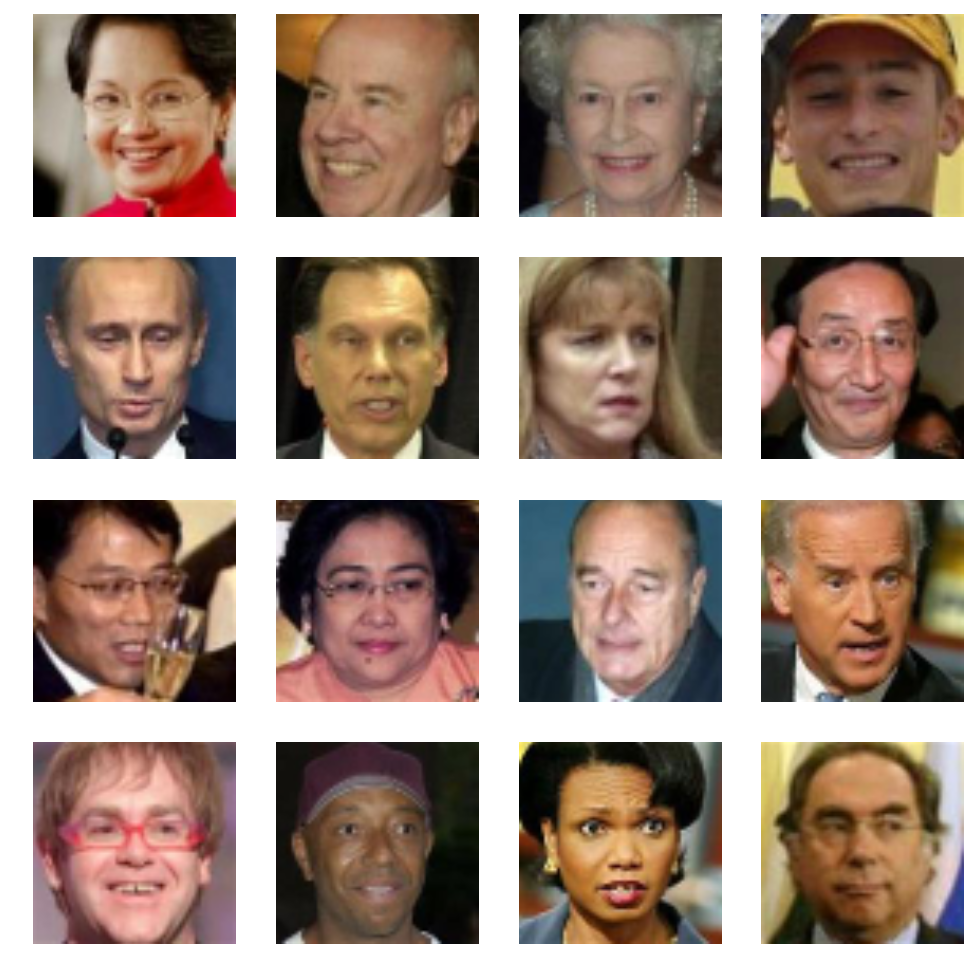

In [26]:
plot_images(X_train[:16], 'test.png')

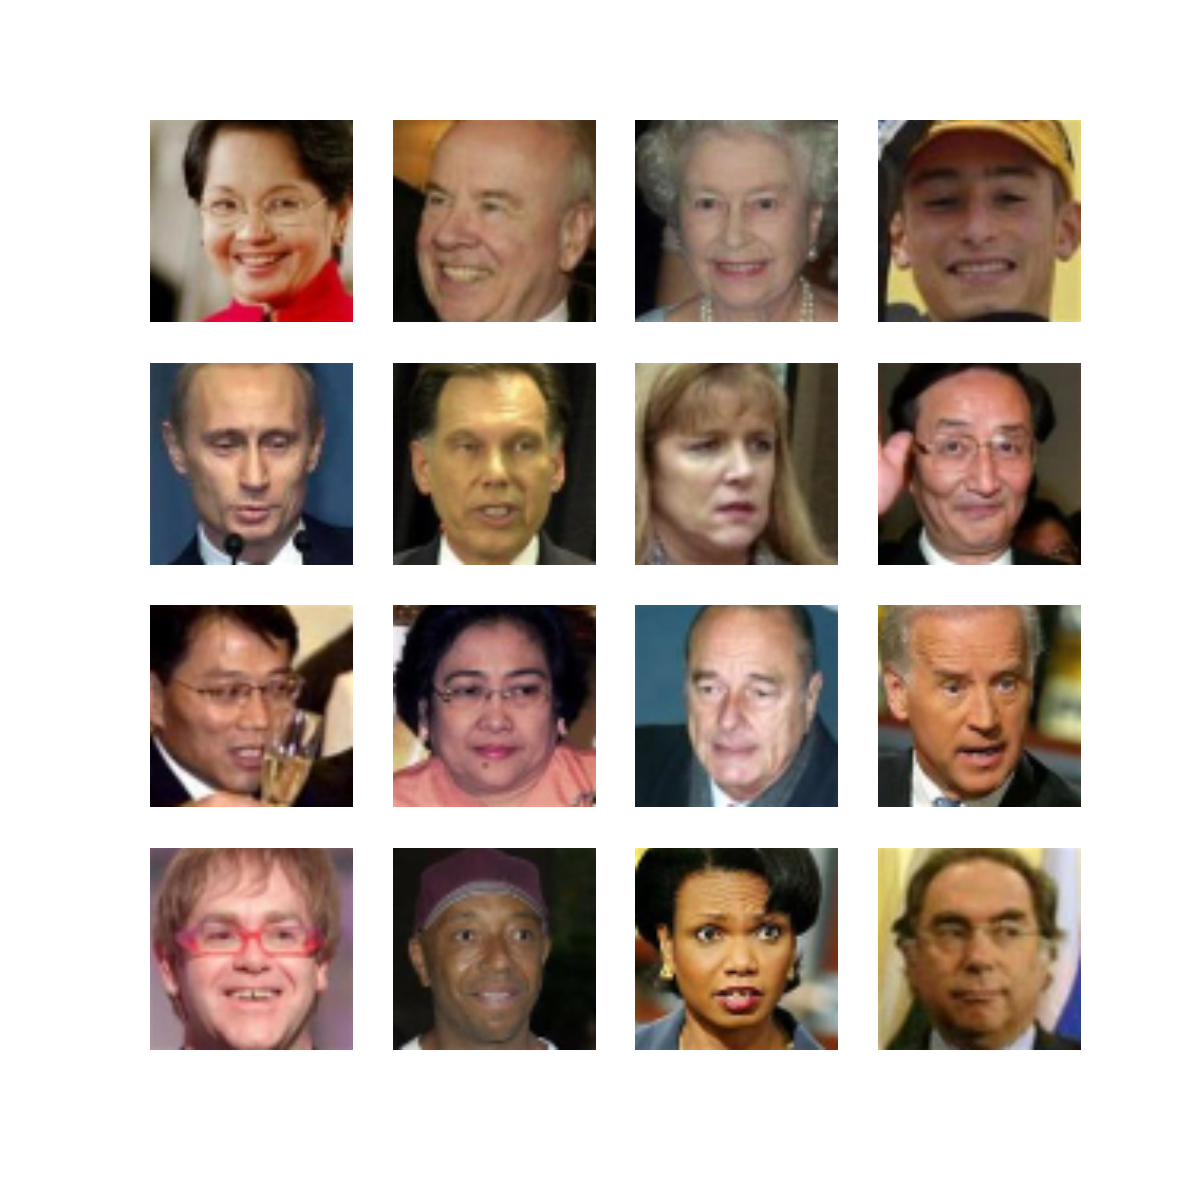

In [27]:
from IPython.display import Image
Image('test.png')